<a href="https://colab.research.google.com/github/maryambahri/IE7500/blob/main/scripts/tweet_sentiment_analysis_and_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>Tweet Sentiment Analysis & Classification</strong></h2>
  <p style="color:#333333;">Using LSTM and BERT on the Sentiment140 Dataset</p>
</div>

placeholder for some brief motivation, problem statement, and goals.

This notebook builds a tweet sentiment classifier using the Sentiment140 dataset. We compare classical and deep learning models (TF-IDF + Logistic Regression, BiLSTM, and DistilBERT) to understand which architecture best captures sentiment in short, informal texts.


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>1. Data Loading & Overview</strong></h2>
  <p style="color:#333333;">Import Sentiment140 dataset and display basic information (shape, sample rows, nulls, etc).</p>
</div>


In [17]:
# importing all libraries here
import gdown
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
import re

Link to original data source:
https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

In [18]:
# Load the raw dataset
os.makedirs("../data", exist_ok=True)

url = f"https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS"
output = "../data/sentiment140.csv"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS
From (redirected): https://drive.google.com/uc?id=1OeMI3bTQHZrCchkI-vMv2Ibv6RLGk7aS&confirm=t&uuid=68fd486c-c2c9-4f08-b62e-3688c3f13c51
To: /data/sentiment140.csv
100%|██████████| 239M/239M [00:01<00:00, 129MB/s]


'../data/sentiment140.csv'

In [19]:
# Naming columns for readability

columns = [
    "target",    # Sentiment (0=negative, 2=neutral, 4=positive)
    "id",        # Tweet ID
    "date",      # Date of tweet
    "flag",      # Query flag
    "user",      # Username
    "text"       # Tweet text
]

df = pd.read_csv(
    "../data/sentiment140.csv",
    encoding='latin-1',
    header=None,
    names=columns
)

In [20]:
# Show first 5 rows

df.head(5)

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>2. Exploratory Data Analysis (EDA)</strong></h2>
  <p style="color:#333333;">Analyze class distribution, tweet length, missing data, and identify patterns or anomalies.</p>
</div>


## **EDA Section**

First, we get a better understading over our dataset

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [22]:
df.describe()

,target,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


### Dataset Overview and Initial Insights

**From `df.info()`:**
- The dataset contains **1,600,000 entries** and **6 columns**: `target`, `id`, `date`, `flag`, `user`, and `text`.
- **No missing values** in any column which means the data is clean.
- **Data types**:
  - `target` and `id`: `int64`
  - `date`, `flag`, `user`, `text`: `object` (which are likely strings)

---

**From `df.describe()`:**

- **`target`**:
  - Range: 0 to 4
  - Mean = 2.0, Std = 2.0 → appears fairly balanced, but needs verification with `value_counts()`.

- **`id`**:
  - Large numeric values, probably unique identifiers (e.g., tweet IDs).
  - Not useful for prediction but useful for indexing or referencing.

---

### Initial Findings Summary

- Data integrity looks solid — **no nulls**, appropriate dtypes.
- `target` is the label column, we will need to examine and check class balance.

### EDA Deep Dives into distributions

In [23]:
# first we fix and convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Create a new column for year
df['year'] = df['date'].dt.year

df.head()


<ipython-input-23-142855988>:2: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


,target,id,date,flag,user,text,year
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,2009
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,2009
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,2009
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",2009


<ipython-input-24-1141603970>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")


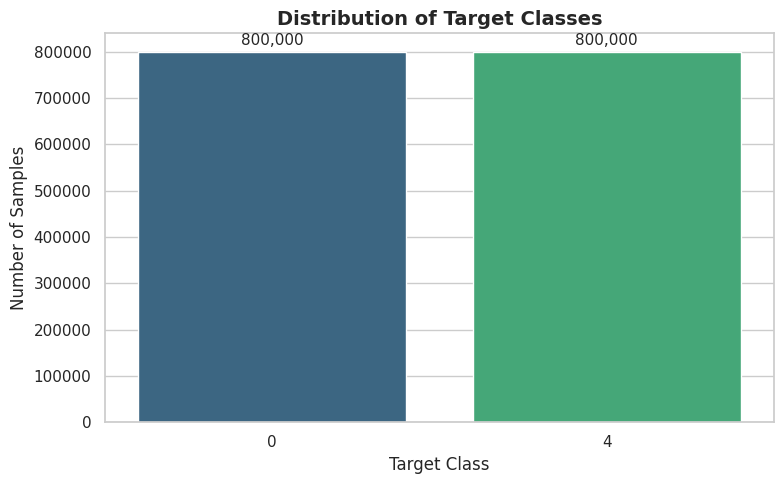

In [24]:
# we now start visualizing the distributions of the target

# Set a clean visual style
sns.set(style="whitegrid")

# Calculate value counts
target_counts = df['target'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=target_counts.index, y=target_counts.values, palette="viridis")

# Add value labels on bars
for i, value in enumerate(target_counts.values):
    plt.text(i, value + max(target_counts.values)*0.01, f'{value:,}',
             ha='center', va='bottom', fontsize=11)

# Titles and labels
plt.title('Distribution of Target Classes', fontsize=14, fontweight='bold')
plt.xlabel('Target Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

plt.show()

#### Bar Chart Distribution Comment:

Despite the Kaggle description suggesting that the dataset includes three sentiment classes (positive, negative, and neutral), this chart reveals that the annotations are limited to only two classes:

0: Negative sentiment

4: Positive sentiment

There are no neutral (class 2) samples present in this dataset.
Additionally, the distribution appears to be perfectly balanced, with approximately 800,000 samples in each class. This is ideal for training a binary classifier, as it minimizes issues related to class imbalance.

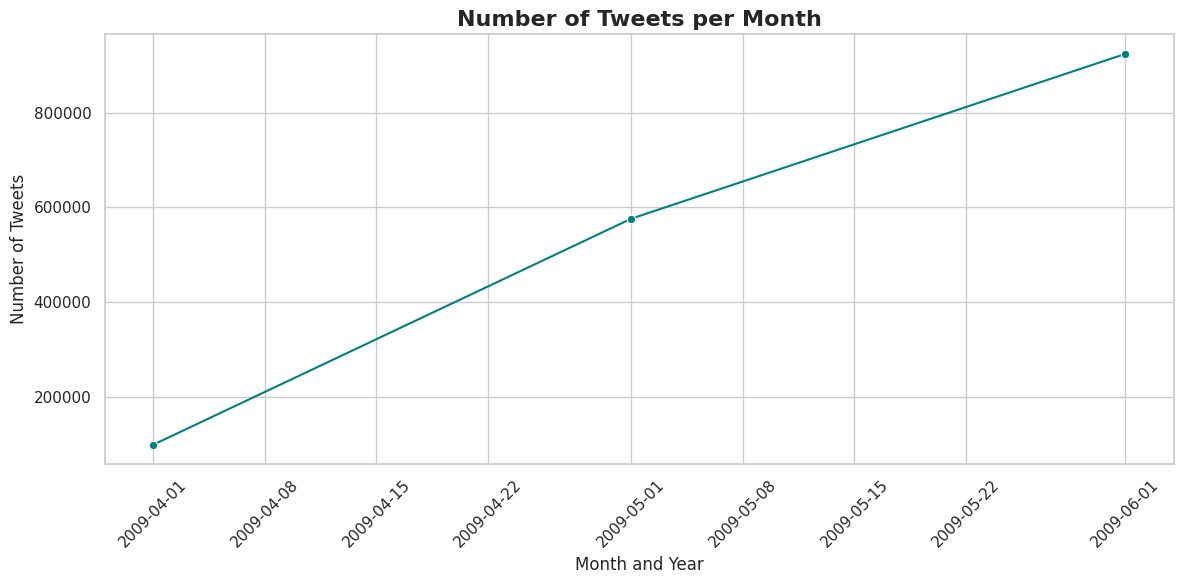

In [25]:
# We now examine the number of tweet samples we have by month and year

# Create the 'year_month' column
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Group by year_month and count tweets
monthly_counts = df.groupby('year_month').size().reset_index(name='tweet_count')

# Set style
sns.set(style='whitegrid')

# Convert year_month to datetime for proper ordering in the x-axis
monthly_counts['year_month'] = pd.to_datetime(monthly_counts['year_month'])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x='year_month', y='tweet_count', marker='o', color='teal')

# Labels and title
plt.title("Number of Tweets per Month", fontsize=16, fontweight='bold')
plt.xlabel("Month and Year", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Line Plot Comment for Tweet Volume Over Time

This line chart shows the number of tweets collected over time based on the Sentiment140 dataset.

From the visualization, we observe that the tweets were collected over a short time span — specifically over a period of **approximately three months in 2009**.

- The dataset begins in **April 2009** and ends by **early June 2009**, suggesting a **single batch collection** during that year.
- This concentrated sampling period should be considered during any temporal or trend-based analysis, as it does not cover a full year or span multiple time periods.


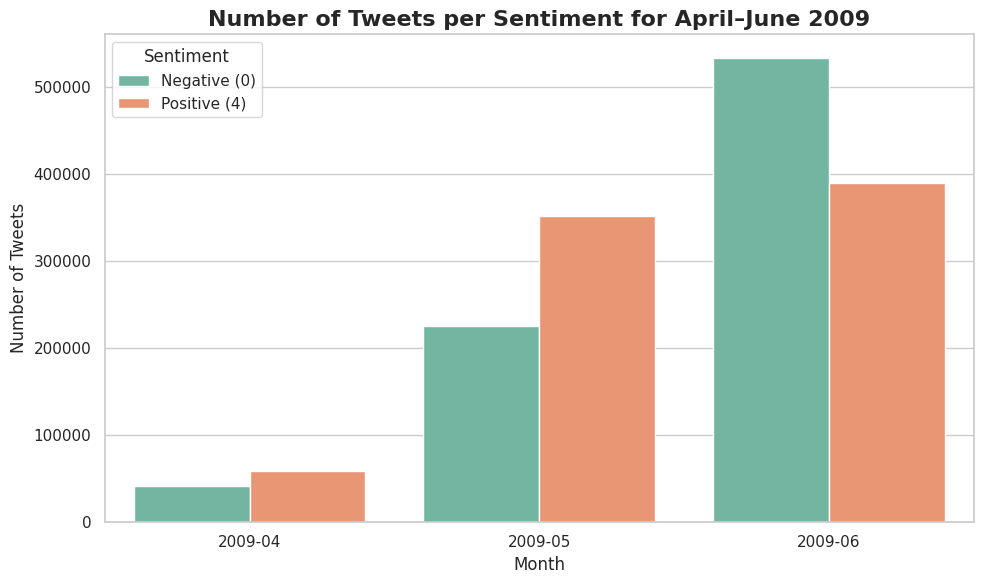

In [26]:
# Examine tweets distribution by month

# Extract month-year in 'YYYY-MM' format
df['month'] = df['date'].dt.to_period('M').astype(str)

# Count tweets by month and target
monthly_sentiment_counts = (
    df.groupby(['month', 'target'])
    .size()
    .reset_index(name='tweet_count')
)

# Define custom color palette to control bar and legend color mapping
palette = {
    0: '#66c2a5',  # Greenish for Negative
    4: '#fc8d62'   # Orangish for Positive
}

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=monthly_sentiment_counts,
    x='month', y='tweet_count', hue='target',
    palette=palette
)

# Labels and title
plt.title('Number of Tweets per Sentiment for April–June 2009', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)

# Fix legend to match colors and labels
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=['Negative (0)', 'Positive (4)'], title='Sentiment')

plt.tight_layout()
plt.show()


### Analyzing Number of Tweets per Sentiment for April–June 2009

This bar chart visualizes the number of tweets labeled as **negative (0)** and **positive (4)** across the three months covered by the dataset: **April, May, and June 2009**.

#### Key Insights:
- Tweet volume **increased steadily each month**, peaking in June 2009.
- In **April**, tweet volume was relatively low and slightly favored **positive sentiment**.
- In **May**, the number of tweets grew substantially, with a notable rise in **positive tweets**.
- By **June**, the volume of **negative tweets** overtook positive ones, reaching the highest count in the dataset.

This temporal breakdown shows both an overall **growth in Twitter samples collected** and **variation in sentiment dynamics** during this short collection window.


<ipython-input-27-4040999392>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='target', y='text_length', palette='Set2', inner='quartile')


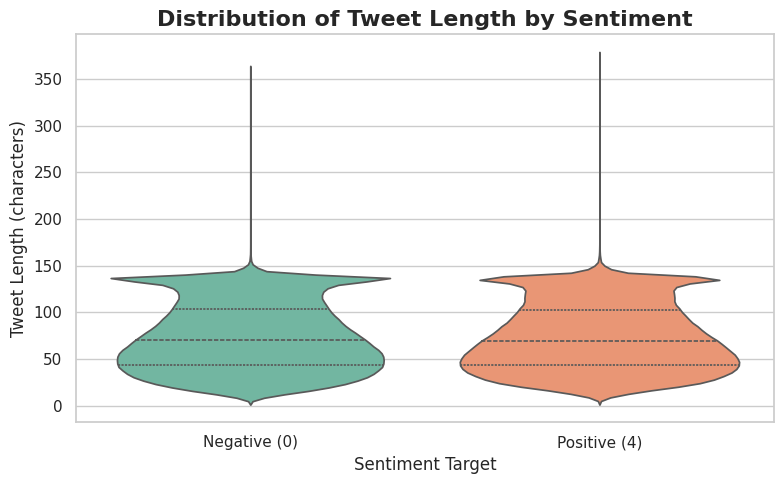

In [27]:
# We now visualize the violin plot for each target by tweet length

# Add a new column for tweet length
df['text_length'] = df['text'].str.len()

# Violin plot of tweet length by sentiment
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x='target', y='text_length', palette='Set2', inner='quartile')

plt.title("Distribution of Tweet Length by Sentiment", fontsize=16, fontweight='bold')
plt.xlabel("Sentiment Target", fontsize=12)
plt.ylabel("Tweet Length (characters)", fontsize=12)
plt.xticks([0, 1], ["Negative (0)", "Positive (4)"], fontsize=11)
plt.tight_layout()
plt.show()

#### Distribution of Tweet Length by Sentiment

This violin plot illustrates the distribution of tweet lengths (in characters) for each sentiment class in the dataset:

- **Negative tweets (target = 0)**  
- **Positive tweets (target = 4)**

Key observations:
- The **distribution shapes** for both sentiments are fairly similar, suggesting that tweet length is not strongly associated with sentiment polarity.
- Most tweets fall within the **50 to 120 character** range for both classes.
- There are a few **longer tweets (up to ~360 characters)**, but they are rare and do not skew the distribution significantly.
- The **thickness of the violin** indicates the density — most tweets cluster around the 40–100 character range.

Conclusion:  
Tweet length appears to have a **amost exact pattern** across both positive and negative sentiments, and is therefore unlikely to be a strong discriminative feature on its own.


In [28]:
# Counting the number of tweets with special characters, and those that are a response to other users

# Define a regex pattern for special characters (excluding whitespace and alphanumerics)
special_char_pattern = r"[^\w\s]"  # matches anything that's not a-z, A-Z, 0-9, or whitespace

# Count tweets that contain at least one special character
num_special_chars = df['text'].str.contains(special_char_pattern).sum()

# Count tweets that start with a mention (starts with '@')
num_mentions = df['text'].str.startswith('@').sum()

# Output
print(f"Number of tweets with special characters: {num_special_chars:,}")
print(f"Number of tweets that are mentions (start with @): {num_mentions:,}")


Number of tweets with special characters: 1,449,640
Number of tweets that are mentions (start with @): 698,079


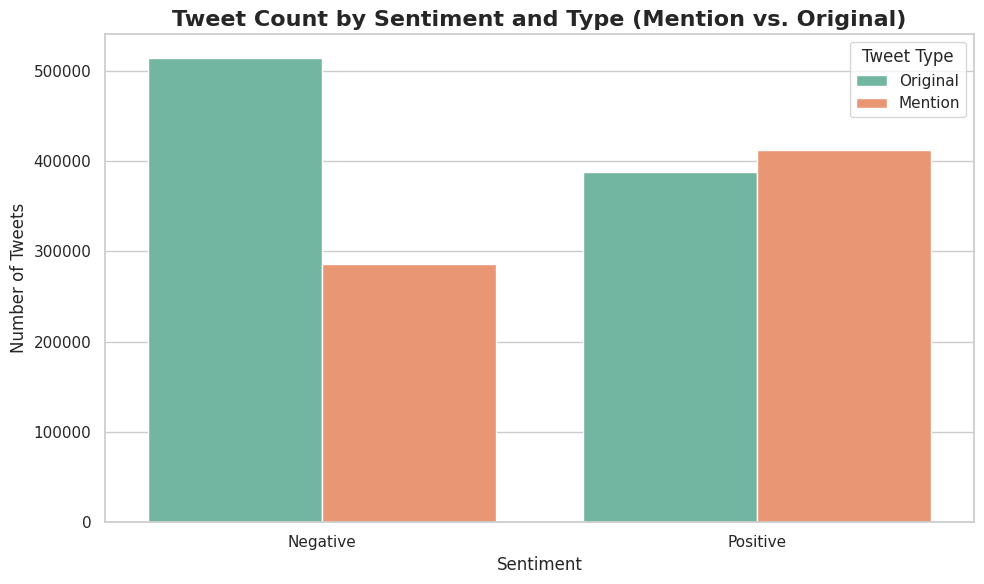

In [29]:
# Now we examine if any pattern arises if the tweet is a response/mention or not

# Create a boolean column: True if tweet starts with '@', else False
df['is_mention'] = df['text'].str.startswith('@')

# Group by sentiment (target) and mention status
mention_sentiment_counts = (
    df.groupby(['target', 'is_mention'])
    .size()
    .reset_index(name='tweet_count')
)

import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for the sentiment and mention columns
mention_sentiment_counts['Sentiment'] = mention_sentiment_counts['target'].map({0: 'Negative', 4: 'Positive'})
mention_sentiment_counts['Tweet Type'] = mention_sentiment_counts['is_mention'].map({True: 'Mention', False: 'Original'})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=mention_sentiment_counts,
    x='Sentiment', y='tweet_count', hue='Tweet Type',
    palette='Set2'
)

# Labels and title
plt.title('Tweet Count by Sentiment and Type (Mention vs. Original)', fontsize=16, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.legend(title='Tweet Type')
plt.tight_layout()
plt.show()

## General EDA Summary

- The dataset comprises **1.6 million labeled tweets**, split evenly between **positive (target = 4)** and **negative (target = 0)** sentiments.
- There are **no missing or malformed values** across any of the six columns: `target`, `id`, `date`, `flag`, `user`, and `text`. This indicates excellent data quality and readiness for downstream processing.
- The **sentiment distribution is perfectly balanced**, with approximately **800,000 samples in each class**. This lack of class imbalance is ideal for training binary classifiers without the need for resampling.
- A violin plot of tweet lengths reveals that both sentiment classes have similar distributions, with most tweets falling in the **40–120 character** range. This implies that **tweet length does not correlate strongly with sentiment**, reducing the risk of unintended bias during modeling.
- Temporal analysis shows that the tweets were collected within a short time span — from **April to June 2009**. Although there is a noticeable increase in tweet volume across these months, the **sentiment proportions remain consistent**, suggesting this variation has **minimal effect on learning or sentiment classification**.
- When breaking down tweets by **type of interaction** (original tweets vs. replies/mentions that begin with `@`), an interesting pattern emerges:
  - **Negative tweets are more likely to be original posts**, while
  - **Positive tweets are more often replies or mentions** to other accounts.
  
  This behavioral difference suggests that **positive sentiment may be more common in interpersonal or interactive tweets**, whereas **negative sentiment might be more frequently expressed in stand-alone posts**. This subtle distinction could have implications for contextual sentiment modeling.

Overall, the dataset is **clean, balanced, and well-structured**, making it a strong foundation for robust sentiment classification using classical or deep learning techniques.


## Key Note

During EDA, we observed a behavioral difference between tweet types:
- **Negative tweets are more likely to be original posts**
- **Positive tweets more frequently occur as replies or mentions (starting with `@`)**

To avoid discarding this valuable context during text preprocessing and to enhance model learning, we will not directly discard @ and lose valuable information.



## Plan to Leverage Tweet Interaction Type (Mentions vs. Original) for NLP Sentiment Classification

- Replace usernames (e.g., `@user123`) with a neutral token like `[USER]`.
- This keeps the context of interaction (e.g., replying to someone) without overfitting to specific handles.

```python
df['clean_text'] = df['text'].str.replace(r'^@\w+', 'MENTION', regex=True)
```


- Create an Explicit Feature column: is_mention

This results in capturing conversational context, which might influence sentiment.




<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>3. Data Preprocessing</strong></h2>
  <p style="color:#333333;">Steps: lowercasing, punctuation & stopword removal, tokenization, stemming, lemmatization, cleaning hashtags, mentions, URLs, numbers.</p>
</div>


- Convert Upper case words to Lower Case
- Change all mentions and charachters attached into "MENTION"
- Download stopwords, punkt_tab using nltk.download() function.
- for the stop_words add punctuations like , . " '
- Remove White space

In [30]:
# importing all libraries here
import numpy as np
import pandas as pd
import gdown
import os
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
import spacy

In [31]:
# Download the stopwords and punkt_tab
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [32]:
#!python -m spacy download en_core_web_lg

In [33]:
# step 1, Convert all cases to lower

tweets = df[['text', 'target']]

tweets['text'] = tweets['text'].str.lower()

tweets.head()

<ipython-input-33-2929434613>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets['text'] = tweets['text'].str.lower()


,text,target
0,"@switchfoot http://twitpic.com/2y1zl - awww, t...",0
1,is upset that he can't update his facebook by ...,0
2,@kenichan i dived many times for the ball. man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [34]:
# step 2, convert all mentions and the mentioned account names to MENTION

# Make a copy to avoid modifying the original DataFrame
tweets = df[['text', 'target']].copy()

# Convert to lowercase
tweets['text'] = tweets['text'].str.lower()

# Replace all @mentions with "MENTION"
tweets['text'] = tweets['text'].str.replace(r'@\w+', 'MENTION', regex=True)

tweets.head()

,text,target
0,"MENTION http://twitpic.com/2y1zl - awww, that'...",0
1,is upset that he can't update his facebook by ...,0
2,MENTION i dived many times for the ball. manag...,0
3,my whole body feels itchy and like its on fire,0
4,"MENTION no, it's not behaving at all. i'm mad....",0


In [35]:
# Step #3, we tokenize the words and remove stop words

# Load NLP model
nlp = spacy.load('en_core_web_lg')

# Setup
tweets_array = tweets.to_numpy(copy=True)  # preserve the original DataFrame
stop_words = set(stopwords.words('english'))

# Add extra symbols to stop words
stop_words.update(string.punctuation)
stop_words.update(["''", "'", '``', '’', '“', '”','–', '—', '…', '..', '.', ',', ':', ';', '?', '!', '(', ')', '[', ']', '{', '}', '/', '|'])

# Stemmers / lemmatizers
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Preprocess each tweet
for i in range(len(tweets_array)):
    text = tweets_array[i][0]  # Access the tweet text

    # Remove numbers and whitespace
    text = ''.join((z for z in text if not z.isdigit()))
    text = ' '.join(text.split())

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(word.lower()) for word in tokens]

    # Rejoin or store as tokens
    tweets_array[i][0] = ' '.join(tokens)

# Convert back to DataFrame
preprocessed_tweets = pd.DataFrame(tweets_array, columns=['text', 'target'])

preprocessed_tweets.head()

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4. Baseline Model – TF-IDF + Logistic Regression</strong></h2>
  <p style="color:#333333;">TF-IDF vectorization + logistic regression as a benchmark.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>5. LSTM Model</strong></h2>
  <p style="color:#333333;">Bidirectional LSTM with pre-trained embeddings (e.g., GloVe).</p>
</div>


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>6. BERT Model</strong></h2>
  <p style="color:#333333;">Fine-tuning DistilBERT or similar transformer model (if feasible).</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>7. Model Evaluation Comparison</strong></h2>
  <p style="color:#333333;">Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>8. Conclusion</strong></h2>
  <p style="color:#333333;">Summarize findings and insights, discuss trade-offs, and generalization potential.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>9. Future Work</strong></h2>
  <p style="color:#333333;">Suggest future extensions like streaming integration or domain adaptation.</p>
</div>
